In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import seaborn as sns
from os.path import join as pjoin
from scipy.signal import butter, filtfilt, resample
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.2)

In [2]:
def load_edf_signal(file, f_low = 0.3, f_high = 35):
    file_name = pjoin('data/', file)

    # Load whole night PSG sleep data (EEG, EOG, EMG and EKG signals)
    raw = mne.io.read_raw_edf(file_name, preload=True, verbose=0)
    # Let’s remove the EOG, EMG and EKG channels:
    # print(f'All channels:\n{raw.ch_names}')
    raw.drop_channels(['ECG', 'EOG1-A1', 'EOG2-A1', 'EMG1'])
    # print(f'Selected channels:\n{raw.ch_names}')

    # Check the sampling frequency of the data in Hertz (Hz):
    # print(f'Original fs: {raw.info["sfreq"]} Hz')
    raw_downsampled = raw.copy().resample(sfreq=200)

    # print(f'\nNew sampling frequency: {raw.info["sfreq"]} Hz')
    raw_downsampled.filter(f_low, f_high, verbose=0)

    data_filtered = raw_downsampled.get_data(units="uV", verbose=0)
    return data_filtered, raw_downsampled

In [3]:
# Define bandpass filter
def bandpass_filter(x, f_low, f_high, fs, n):
  f_nyquist = 0.5 * fs
  low = f_low / f_nyquist
  high = f_high / f_nyquist
  b, a = butter(n, [low, high], btype="band")
  y = filtfilt(b, a, x)
  return y

In [4]:
from scipy.signal import resample

def resample_sig(sig, fs_res=200):
    # Resampling
    n_samps = sig.shape[0] # Number of samples in signal
    time_seconds = 1800  # 30 minutes = 1800 seconds

    fs = n_samps / time_seconds
    n_samps_res = int(n_samps/fs*fs_res) # Number of samples in signal after resampling
    return resample(sig, n_samps_res)

In [5]:
def load_txt_signal(file, f_low, f_high):
    file_name = pjoin('data/', file)

    # data is for channel C3-A1
    data = np.loadtxt(file_name, skiprows=1)

    # resample
    resampled = resample_sig(data)
    # filter
    filtered = bandpass_filter(resampled, f_low, f_high, 200, 4)

    return filtered

In [6]:
# Filtering
f_low = 0.3
f_high = 35
n = 2
fs = 200

In [7]:
patients = []
patients_raw = []

for file in tqdm(os.listdir('data')):
    if file.startswith('excerpt1') and file.endswith('.txt'):
        txt_data = load_txt_signal(file=file, f_low=0.3, f_high=35)
        patients.append(txt_data)

    if file.startswith('excerpt') and file.endswith('.edf'):
        filtered_data, raw = load_edf_signal(file=file, f_low=0.3, f_high=35)
        patients.append(filtered_data)
        patients_raw.append(raw)

  0%|          | 0/47 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished
 26%|██▌       | 12/47 [00:01<00:04,  8.38it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 |

# da qui ho fatto

In [8]:
from scipy.stats import entropy, kurtosis, skew
from scipy.signal import hilbert, welch

def extract_features(data, sfreq):
    # Initialize feature vector
    features = []

    # Define window size and step size (in samples)
    win_size = int(0.5 * sfreq)
    step_size = int(0.5 * sfreq)

    # Iterate over data with sliding window
    for i in tqdm(range(0, data.shape[0], step_size)):
        win = data[i:i+win_size]

        e = entropy(win, base=2)
        if np.isinf(e):
            e = -np.log2(1e-9)

        max_val = win.max()
        min_val = win.min()

        var = win.var()
        std = win.std()

        analytic_signal = hilbert(win)
        amplitude_envelope = np.abs(analytic_signal)
        phase = np.unwrap(np.angle(analytic_signal))
        pac = np.mean(np.multiply(amplitude_envelope, np.cos(phase)))

        freqs, power = welch(win, fs=200)
        freq_index = np.argmax(power[(freqs >= 4) & (freqs <= 30)])
        inst_freq = freqs[freq_index]

        energy_ratio = power[(freqs >= 11) & (freqs <= 16)].sum() / power.sum()

        kurt = kurtosis(win)
        skewness = skew(win)

        pwr_peak = freqs[power.argmax()]
        pwr_ratio = power[(freqs >= 4) & (freqs <= 30)].sum() / power.sum()

        iqr = np.percentile(win, 75) - np.percentile(win, 25)

        zero_crossing = np.where(np.diff(np.signbit(win)))[0].size

        features.append([e, max_val, min_val, var, std, pac, inst_freq, energy_ratio, kurt, skewness, pwr_peak, pwr_ratio, iqr, zero_crossing])

    # Convert feature vector to numpy array and return
    return np.array(features)

In [9]:
mat = pd.DataFrame(columns=['entropy',
                                'max',
                                'min',
                                'var',
                                'std',
                                'pac',
                                'inst_freq',
                                'enegry_ratio',
                                'kurt',
                                'skew',
                                'pwr_peak',
                                'pwr_ratio',
                                'iqr',
                                'zero_crossing'])

In [10]:
# Extract features for channel CZ-A1 for each patient
matrices = []

# text-only patient (patient 1)
feat = patients[0]
sfreq = 200
curr_feats = extract_features(feat, sfreq)
patient_mat = pd.concat([mat, pd.DataFrame(curr_feats, columns=mat.columns)])

matrices.append(patient_mat)


for raw, patient in zip(patients_raw, patients[1:]):
    # patients with complementary raw file
    df = raw.to_data_frame()
    if "CZ-A1" in df.columns:
        _feat_index = df.columns.get_loc("CZ-A1")
    elif  "C3-A1" in df.columns:
        _feat_index = df.columns.get_loc("C3-A1")

    feat = patient[_feat_index]
    sfreq = raw.info['sfreq']
    curr_feats = extract_features(feat, sfreq)
    patient_mat = pd.concat([mat, pd.DataFrame(curr_feats, columns=mat.columns)])
    
    matrices.append(patient_mat)

100%|██████████| 3600/3600 [00:05<00:00, 694.55it/s]


# Create X and y

In [20]:
plot = []

X = []  # features
y = []  # labels
for i in range(1, 9):
    ad = np.loadtxt(f'data/Automatic_detection_excerpt{i}.txt', skiprows=1)
    vs1 = np.loadtxt(f'data/Visual_scoring1_excerpt{i}.txt', skiprows=1)
    if os.path.exists(f'data/Visual_scoring2_excerpt{i}.txt'):
        vs2 = np.loadtxt(f'data/Visual_scoring2_excerpt{i}.txt', skiprows=1)

    # Concatenate vertically
    concatenated = np.vstack((ad, vs1, vs2))

    # Sort based on first column
    sorted_indices = np.argsort(concatenated[:, 0])
    data = concatenated[sorted_indices]

    plot.append(data.shape)

    X_patient = matrices[i-1]

    #### correction ####
    # data used to get the shape of the original signal
    # need to be data resampled so that every file has the same shape
    original_signal = load_txt_signal(file=f'excerpt{i}.txt', f_low=0.3, f_high=35)
    
    ####################

    y_patient = np.zeros(original_signal.shape[0])  # set labels to 0 for all windows
    for spindle in data:
        start_idx = int(sfreq * spindle[0])
        duration_idx = int(sfreq * spindle[1])
        interval_indices = np.logical_and(
            np.arange(original_signal.shape[0]) >= start_idx,
            np.arange(original_signal.shape[0]) < start_idx + duration_idx
            )

        # Set the corresponding elements of y_patient to 1
        y_patient[interval_indices] = 1

    # Define window size and step size (in samples)
    win_size = int(0.5 * sfreq)
    step_size = int(0.5 * sfreq)

    label = []
    # Iterate over data with sliding window
    for k in tqdm(range(0, y_patient.shape[0], step_size)):
        win = y_patient[k:k+win_size]
        label.append(round(win.mean()))
    
    X_patient['patient'] = i
    X.append(X_patient)
    y.append(label)

    print(np.unique(label, return_counts=True))


# Combine data from all patients
X = np.concatenate(X)
y = np.concatenate(y)

pd.concat(matrices).to_csv('features.csv')
pd.DataFrame(y, columns=["Target"]).to_csv('target.csv')

100%|██████████| 3600/3600 [00:00<00:00, 119979.14it/s]


(array([0, 1]), array([3191,  409], dtype=int64))


100%|██████████| 3600/3600 [00:00<00:00, 116101.73it/s]


(array([0, 1]), array([3363,  237], dtype=int64))


100%|██████████| 3600/3600 [00:00<00:00, 105859.59it/s]


(array([0, 1]), array([3480,  120], dtype=int64))


100%|██████████| 3600/3600 [00:00<00:00, 112472.96it/s]


(array([0, 1]), array([3414,  186], dtype=int64))


100%|██████████| 3600/3600 [00:00<00:00, 119973.42it/s]


(array([0, 1]), array([3367,  233], dtype=int64))


100%|██████████| 3600/3600 [00:00<00:00, 112477.15it/s]


(array([0, 1]), array([3332,  268], dtype=int64))


100%|██████████| 3600/3600 [00:00<00:00, 124109.17it/s]


(array([0, 1]), array([3351,  249], dtype=int64))


100%|██████████| 3600/3600 [00:00<00:00, 114244.71it/s]


(array([0, 1]), array([3157,  443], dtype=int64))


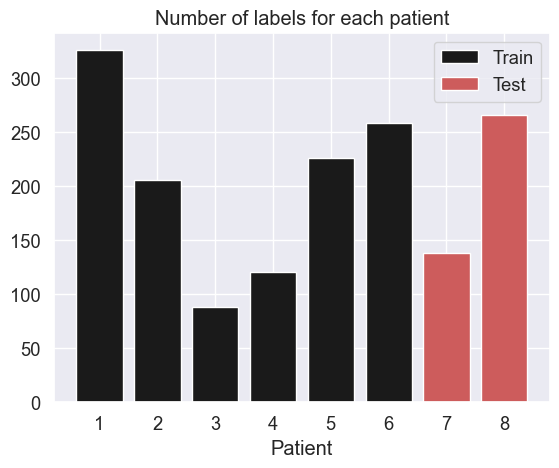

In [16]:
# shape of the labels for each patient
a = np.array([(i+1, plot[i][0]) for i in range(len(plot))])
a = a.reshape(-1,2)

# Separate the data into x and y arrays
x = a[:, 0]
y = a[:, 1]


# Create bar plot
fig, ax = plt.subplots()
ax.bar(x[:-2], y[:-2], color='k', label='Train')
ax.bar(x[-2:], y[-2:], color='indianred', label='Test')

# Set labels and legend
ax.legend()
ax.set_xlabel("Patient")
plt.xticks(x)
plt.title("Number of labels for each patient")
plt.show()